## Imports

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm import tqdm

from scipy.interpolate import griddata

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from iudx.entity.Entity import Entity
from iudx.auth.Token import Token

import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geojsoncontour

import ipywidgets as widgets
from ipywidgets import Layout

import warnings
warnings.filterwarnings('ignore')

## Fetching AQM data

In [31]:
#Get token from backend, this is automatic in the sandbox environment
token = Token(auth_url="https://authorization.iudx.org.in/auth/v1/token", token_file='/tmp/credentials.json')

"""
If running locally, you need to provide your client credentials as shown below
"""
# client_id=input("Client ID")
# client_secret=input("Client Secret")
# token = Token(client_id=client_id, client_secret=client_secret)

token.set_item(
    item_id="rs.iudx.org.in",
    item_type="resource_server",
    role="consumer")

# Resource group ID for Pune AQM sensors
item_id="datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm"

# Set a private resource to access.
token.set_item(
    item_id=item_id,
    item_type="resource_group",
    role="consumer")

# Creating an entity for the resource-group (use the token parameter to access private resources)
# Make sure all the resources in the group have the same schema (Ex. Pune AQM)
entity = Entity(item_id, token_obj=token)

# create a during query for a time interval.
# aqm = entity.during_search(
#          start_time="2022-02-22T00:00:00Z",
#          end_time="2022-03-22T00:00:00Z"
#      )

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/credentials.json'

In [7]:
# Read data for the month of January
# Datasets for other time periods can be found on the Sandbox page here
# https://sandbox.iudx.org.in/dataset/datakaveri.org-f7e044eee8122b5c87dce6e7ad64f3266afa41dc-cat-sandbox.iudx.org.in-pune-env-aqm

aqm=pd.read_parquet('https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/pune-aqm-data/pune-aqm-jan.parquet').drop_duplicates()

## Location of sensors across the city

Gathering location and labels from entity metadata 

In [8]:
rsc_dict={}
for rsc in entity.resources:
    rsc_dict[rsc['id']]={
        'coordinates':rsc['location']['geometry']['coordinates'],
        'label':rsc['label']
    }

Spatial visualization using Foilum

In [9]:
sensors_map=folium.Map()
for rsc_id, rsc in rsc_dict.items():
    folium.Marker([rsc["coordinates"][1], rsc["coordinates"][0]],
                  tooltip=rsc['label']).add_to(sensors_map)
sensors_map.fit_bounds(sensors_map.get_bounds())
sensors_map

In [10]:
# adding sensor location and label information to the dataframe
aqm['latitude']=aqm['id'].apply(lambda id:rsc_dict[id]['coordinates'][1])
aqm['longitude']=aqm['id'].apply(lambda id:rsc_dict[id]['coordinates'][0])
aqm['label']=aqm['id'].apply(lambda id:rsc_dict[id]['label'])

In [11]:
print(f'No. of active sensors in the time period: {len(np.unique(aqm.label))}')

No. of active sensors in the time period: 50


## Fetching the latest live data

In [12]:
aqm_latest=entity.latest()
aqm_latest['latitude']=aqm_latest['id'].apply(lambda id:rsc_dict[id]['coordinates'][1])
aqm_latest['longitude']=aqm_latest['id'].apply(lambda id:rsc_dict[id]['coordinates'][0])
aqm_latest['label']=aqm_latest['id'].apply(lambda id:rsc_dict[id]['label'])

## Widgets

In [13]:
column_choice=['airTemperature','ambientNoise','so2','uv','co','co2','atmosphericPressure',
               'illuminance','no2','o3','pm10','pm2p5','relativeHumidity']

In [14]:
prompt1=widgets.HTML(value="")
prompt2=widgets.HTML(value="")
gif_address = 'https://www.uttf.com.ua/assets/images/loader2.gif'

# drop down widget to choose pollutant/property
select_col=widgets.Dropdown(
    options=column_choice,
    value='pm10',
    description='Property:',
    disabled=False,
)

time_range=pd.date_range(datetime(2022,3,21,0), datetime(2022,3,22,0), freq='H')
options = [time.strftime('%d %b %H:%M:%S') for time in time_range]
index = (0, len(options)-1)

# Slider to choose time
select_time=widgets.SelectionSlider(
    options=options,
    value=options[-1],
    description='Time:',
    disabled=False,
    orientation='horizontal',
    continuous_update=False,
    readout=True,
    width=1000,
)
mywidgets=[select_col]
ui=widgets.VBox([prompt1,select_col,select_time,prompt2],width=500)

## Interpolating pollutant readings across the city

In [15]:
# FUNCTION TO PLOT CONTOUR MAP AFTER CUBIC INTERPOLATION
def pollutant_contour(pollutant,time):
    prompt2.value='Building Contour ...'
    
    # GATHER THE REQUIRED DATA FOT THE CHOSEN TIME
    time=datetime.strptime(time+' 2022','%d %b %H:%M:%S %Y')
    aqm_latest=aqm[aqm.observationDateTime<time.strftime('%d-%m-%Y %H:%M:%S')]
    aqm_latest=aqm_latest.sort_values(by='observationDateTime').drop_duplicates(['id'],keep='last')

    pollutant=pollutant+'.avgOverTime'
    data=aqm_latest.dropna(subset=[pollutant])
    readings=data[pollutant]
    x=data['longitude']
    y=data['latitude']
    sensors=list(np.unique(data.id))
    
    #BUILDING A MESH GRID FOR A GIVEN RESOLUTION
    res=500
    y_arr = np.linspace(np.min(y), np.max(y), res)
    x_arr = np.linspace(np.min(x), np.max(x), res)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    
    # PERFORM CUBIC INTERPOLATION
    interpolated_readings = griddata((x, y), readings, (x_mesh, y_mesh), method='cubic')
    
    # PLOT CONTOUR
    levels = 50
    contourf=plt.contourf(x_mesh, y_mesh, interpolated_readings, levels, alpha=0.5, 
                          cmap="bwr", linestyles='None', vmin=0)
    plt.close()

    # CONVERT CONTOUR TO GEOJSON REPRESENTION
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    sensors_map=folium.Map(tiles="cartodbpositron")
    
    # UNCOMMENT THE FOLLOWING LINES TO PLOT THE SENSOR LOCATIONS AS WELL
    # for rsc_id, rsc in rsc_dict.items():
    #     if rsc_id in sensors:
    #         folium.Marker([rsc["coordinates"][1], rsc["coordinates"][0]],
    #                       tooltip=rsc['label']).add_to(sensors_map)

    # PLOT CONTOUR ON MAP WITH FOLIUM 
    folium.GeoJson(
        geojson,
        style_function=lambda x: {
            'color':     x['properties']['stroke'],
            'weight':    x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity':   0.6,
        }).add_to(sensors_map)

    sensors_map.fit_bounds(sensors_map.get_bounds())
    
    prompt2.value=str(time)
    
    display(sensors_map)

In [16]:
display(ui)
widgets.interactive_output(pollutant_contour,{'pollutant':select_col,'time':select_time})

Output()

## Correlation check between two sensors in close proximity

In [17]:
# CONVERTING OBSERVATIONDATETIME FROM STRING TO DATETIME
aqm['observationDateTime']=aqm['observationDateTime'].apply(lambda x:str(x).split('+')[0])
aqm['observationDateTime']=pd.to_datetime(aqm['observationDateTime'])

In [18]:
# function to min-max scale data
def scale_data(values:list):
    return [(v-min(values))/(max(values)-min(values)) for v in values]

#### Visualizing the trends

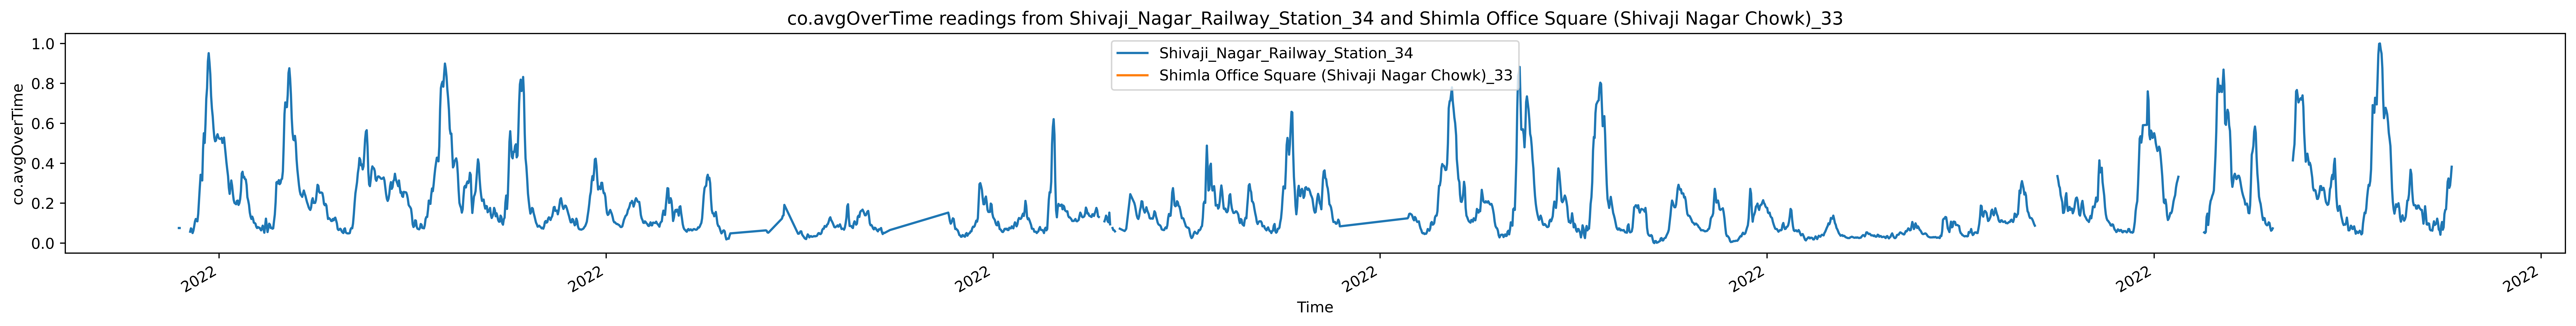

In [19]:
# CHOOSE POLLUTANT AND SENSOR LABELS TO CHECK FOR CORRELATION
pollutant='co.avgOverTime'
sensor1='Shivaji_Nagar_Railway_Station_34'
sensor2='Shimla Office Square (Shivaji Nagar Chowk)_33'

# GATHER THE REQUIRED READINGS
s1_df=aqm[aqm.label==sensor1]
s2_df=aqm[aqm.label==sensor2]

time1=s1_df.observationDateTime
readings1=s1_df[pollutant]
time2=s2_df.observationDateTime
readings2=s2_df[pollutant]

# SCALE THE DATA INTO [0,1]
readings1=scale_data(readings1)
readings2=scale_data(readings2)

# PLOT
plt.figure(figsize=(30,3),dpi=700)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(time1,readings1,label=sensor1)
plt.plot(time2,readings2,label=sensor2)
plt.gcf().autofmt_xdate()
plt.title(f'{pollutant} readings from {sensor1} and {sensor2}')
plt.xlabel('Time')
plt.ylabel(pollutant)
plt.legend()

plt.show()

## Forecasting with ARIMA

In [27]:
sensor='Jhanshi Rani Square_59'
sensor_data=aqm[aqm.label==sensor].dropna(subset=[pollutant]).reset_index(drop=True)

In [28]:
pollutant='co.avgOverTime'
readings=list(sensor_data[pollutant])

# SPLIT INTO HISTORICAL AND TEST DATA
slice_index=int(0.9*len(readings))
history, test_arima=readings[:slice_index],readings[slice_index:]
predictions = list()

# PREDICTIONS USING ARIMA
for t in tqdm(range(len(test_arima))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test_arima[t])
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


MSE 0.17
MAE 0.17
R2 0.85


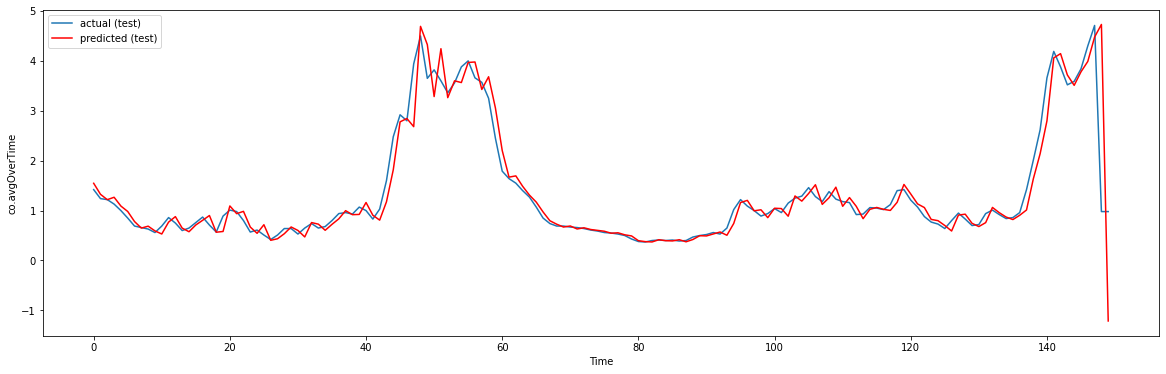

In [29]:
# ERROR METRICS
print(f'MSE {round(mean_squared_error(test_arima, predictions), 2)}')
print(f'MAE {round(mean_absolute_error(test_arima, predictions), 2)}')
print(f'R2 {round(r2_score(test_arima, predictions), 2)}')

# VISUALIZING THE PREDICTIONS
plt.figure(1,(20,6))
plt.plot(test_arima,label='actual (test)')
plt.plot(predictions, color='red',label='predicted (test)')
plt.legend()
plt.xlabel("Time")
plt.ylabel(f"{pollutant}")
plt.show()